# Lab 6 - Classifiers Boosting Algorithms

In this lab, we will implement the AdaBoost algorithm as an ensemble learning technique which
aims to combine a number of weak classifiers to yield a strong classifier at the end.
The idea of this lab is to identify whether a tumor with given characteristics is malignant or
benign. This is a two-class classification problem.

## Dataset and Features

You will be working on the dataset from *Hastie et al,* for breast tumor classification with 10 features representing the tumor's:

                              1. Area            6. Texture
                              2. Perimeter       7. Symmetry
                              3. Radius          8. Greyscale Level
                              4. Compactness     9. Fractal Dimension
                              5. Concavity      10. Coastline Approximation.
There is one output variable which is diagnosis. It takes one of two values `+1` for malignant and `-1` for benign.

### Question 1:
Why it is sometimes better to have the two class values `+1` and `-1` instead of `+1`
and `0`?\
**HINT :** Think about the voting scheme at the end of the boosting algorithm. How can the class values
affect this scheme?

In [154]:
'''
    Your answer: 
    so that we can get the weighted prediction of the data
    it will help us to take the majority vote 
    then we can calculate the accuracy

    if we use 1 and 0, then we can't multiply by the new weights as anything multiplied by 0 is 0
'''

"\n    Your answer: \n    so that we can get the weighted prediction of the data\n    it will help us to take the majority vote \n    then we can calculate the accuracy\n\n    if we use 1 and 0, then we can't multiply by the new weights as anything multiplied by 0 is 0\n"

## Requirement
You are required to fill the function `adaboost_classifier(Y_train, X_train, Y_test, X_test, T, clf).`\
This function takes as parameters:

| | |
|:---|:-|
| **Y_train**| The target values for the training set |
| **X_train**| The input features for the training set.|
| **Y_test**| The target values for the test set.|
| **X_test**| The input features for the training set.|
| **T**| The number of iterations of the AdaBoost Algorithm.|
| **clf**| The classifier to be used. (In our case, we are using a decision tree stump as a base classifier). You can use any other classifier.|

This function should return two values:
- The accuracy of the model on the training set.
- The accuracy of the model on the test set.


#### Fair Note:
In the explanation video, we assumed that (T) is the number of models you want to fit. However, this is not always the case. You may have a model base (like here we have decision trees) and you are allowed to use as many of it as you can. So (T) here becomes the number of iterations where your goal is to enhance the performance with as few iterations as possible. 

Do not get confused:
- If your case is you have T models only, we set T = number of models to fit.
- If you are allowed to use as many models as you can (as many decision trees as you need), then T is the number of iterations to choose. In such case, T becomes a parameter controlled by the programmer.

In [155]:
## imports ##
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2

import utils

**NOTE** we prepared some utility functions to help you throughout the lab. please go and check the file *utils.py* and make sure you understand each function and know how to use it.

### TODO: AdaBoost Implementation

AdaBoost is an iterative algorithm that gives weights for the best classifier every iteration, updates weights of the data points, then repeats until convergence.

The steps of the algorithm are:

1. Initialize weights of the training examples:

$$w_{m} = \frac {1}{M}, m = 1,2,...M$$

                                        M: number of training examples. 

2. For t=1 to $T$:

    a) Select a classifier $h_{t}$ that best fits to the training data using weights $w_{m}$ of the training examples.

    b) Compute error of $h_{t}$ as:
$$err_{t} = \frac {\Sigma_{m=1}^{M} w_{m} \phi (c_{m} \neq h_{t}(x_{m}))}{\Sigma_{m=1}^{M} w_{m}}$$

    c) Compute weight of classifier:
$$\alpha_{t} = \log (\frac {1-err_{t}}{err_{t}} )$$

    d) Update weights of wrongly classified examples:
$$w_{m} = w_{m} * \exp^{\alpha_{t} \phi (c_{m} \neq h_{t}(x_{m}))}, \space m = 1 ... M$$

    e) Renormalize weights $w_{m}$


\
3. Output: $C(x)= argmax_{k}\space (\space \Sigma_{t=1}^{T} \alpha_{t} * \phi (h_{t}(x) = k)) \space)$

**Where** in step 2.B and 2.D, the $\phi (y)$ function is called the *miss indicator* function that gives values:

                                     1: if y is True
                                     0: if y is False

In [156]:
def adaboost_classifier(Y_train, X_train, Y_test, X_test, T, clf):
    
    #TODO: FILL THE FUNCTION with the implementation as the steps above

    # TODO [1]: Initialize weights
    # this array should be of the same length as the number of training examples
    # and should be initialized with 1/len(X_train)
    w = np.array([1 / len(X_train) for x in X_train]) ## weights of the training examples

    ## TODO [2]:  Initialize the training and test data with empty array placeholders
    #### Hint: what should be their shape?
    # for each iteration, we will store the predicted class for each example in the traiing and test set
    pred_train = np.zeros((T, len(Y_train))) ## predicted classes of the training examples
    pred_test = np.zeros((T, len(Y_test)))  ## predicted classes of the test examples

    ## TODO [3]: loop over the boosting iterations 
    for i in range(T): 

        # TODO [4]: Fit a classifier with the specific weights 
        ## TODO [4.A]: fit the classifier on the training data
        #### Hint: search how sklearn.tree.DecisionTreeClassifier fits classifier on data
        ### Hint: search for parameter weights in the fit matrix
        clf = clf.fit(X_train, Y_train, w)

        # TODO [4.B]: predict classes for the training data and test data
        pred_train[i] = clf.predict(X_train)
        pred_test[i] = clf.predict(X_test)
        

        # TODO [5]: calculate the miss Indicator function
        miss = pred_train[i] != Y_train
        
        # TODO [6]: calculate the error for the current classifier (err_t)
        err_t = np.sum(np.multiply(w, miss)) / sum(w)  # to ask --> multiply or dot product and why?
        
        # TODO [7]: calculate current classifier weight (Alpha_t)
        alpha_t = np.log((1 - err_t) / err_t)
        
        # TODO [8]: update the weights 
        w = np.multiply(w, np.exp(np.multiply(alpha_t, miss)))
        
        # TODO [9] Add to the overall predictions --> why doing this step?
        # before this step pred_train is either 1 or -1 as we have only 2 classes so we multiply it by alpha_t to get the weighted sum when we compute the accuracy
        # as after the loop, we will sum all the predictions and then take the sign of the sum to get the final prediction --> majority voting
        pred_train[i] = np.multiply(alpha_t, pred_train[i])  # to ask
        pred_test[i] = np.multiply(alpha_t, pred_test[i])  # to ask

        
    # TODO [10]: Return error rate in train and test set
    #### Hint: use function get_accuracy from utils.py
    # we will add the predictions of all the classifiers and then take the sign of the sum to get the final prediction whether -1 or 1
    train_error = utils.get_accuracy(np.sign(np.sum(pred_train, axis=0)), Y_train)
    test_error = utils.get_accuracy(np.sign(np.sum(pred_test, axis=0)), Y_test)
    return train_error, test_error

### Testing the Boosted Classifier

Now we will use the function you implemented to build a classifer.\
You will not change code here, only read the code below and run it to see how **AdaBoost** enhanced the performance.

Reading Data ...
Number of Iterations :  10
Number of Iterations :  60
Number of Iterations :  110
Number of Iterations :  160
Number of Iterations :  210
Number of Iterations :  260
Number of Iterations :  310
Number of Iterations :  360


d:\Academic_college\Third_Year\Second_Term\Neural_Network\Labs\Labs_Repo\Neural-Network-labs\Lab 6 - AdaBoost Classifier\utils.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(range(0, 450, 50))


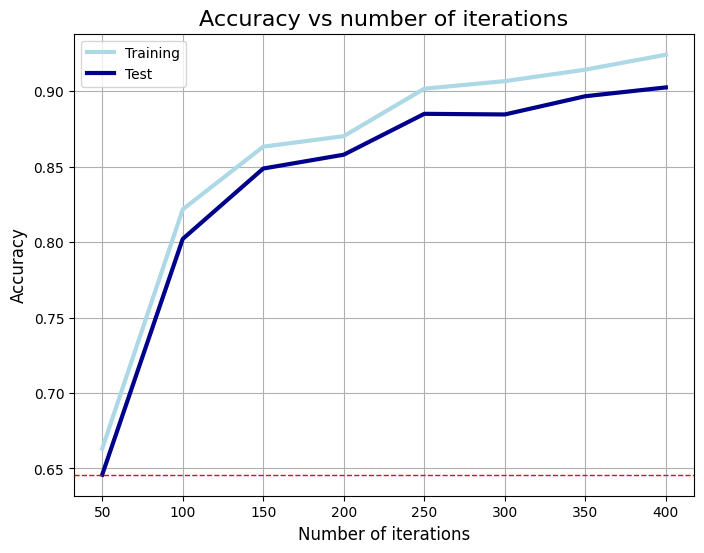

In [157]:
#### DO NOT CHANGE CODE ####

## First, read the dataset
x,y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y
print('Reading Data ...')

# Split into training and test set
train, test = train_test_split(df, test_size=0.2) # this function shuffles the data points, and splits the data into
                                                  # 80% training set and 20% test set (indicated by test_size=0.2)

train, test = np.array(train), np.array(test) # change here --> as an error was raised


X_train, Y_train = train[:, :-1], train[:, -1]  # change here --> as an error was raised
X_test, Y_test = test[:, :-1], test[:, -1]  # change here --> as an error was raised
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth=1, random_state=1)

# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
acc_train, acc_test = [],[]
x_range = range(10, 410, 50)
for i in x_range:
    print('Number of Iterations : ' , i)
    acc_i = adaboost_classifier(Y_train, X_train, Y_test, X_test, i, clf_tree)
    acc_train.append(acc_i[0])
    acc_test.append(acc_i[1])

# Compare error rate vs number of iterations
utils.plot_accuracy(acc_train, acc_test)

### Question 2:
Justify why the plot is the way it is (is it increasing or decreasing? why? when does it flattens out?)

In [158]:
'''
    Your answer:
    it is increasing 
    As the number of iterations increases, the accuracy increases because in each iteration, the classifier is trained on 
    the data points that were misclassified in the previous iteration so it learns from its mistakes
    but we can see that as the iterations increases much, the accuracy doesn't increase much (i.e., the rate of increase becomes very low)

    we can notice that at some point the accuracy may decrease slightly then increases again. 
    this may be wrong or irrelevant updates from the boosting algorithm during this interval, 
    then the model recovers from it and continues improving until flattened out (convergence).
'''

"\n    Your answer:\n    it is increasing \n    As the number of iterations increases, the accuracy increases because in each iteration, the classifier is trained on \n    the data points that were misclassified in the previous iteration so it learns from its mistakes\n    but we can see that as the iterations increases much, the accuracy doesn't increase much (i.e., the rate of increase is very low)\n    it will flatten out when it converges to the optimal solution\n"

### Question 3

The number of iterations (T) is what we call a hyper parameter:
   - Its value differs from model to model and from problem to problem.
   - Its value is not learnt by time, it is set by the programmer.
   
Suggest ways to select the optimal T keeping in mind that:
   - If T is too big, the training time is large (you loop for T times, each time takes a model to fit and this model might take hours to fit)
   - If T is too small, the boosting might not reach the best values it can get.
   
   

**HINT**: Look at the graph of number of iterations vs performance and search for elbow method. Try to understand it and explain what it does.\
**HINT**: There are other hyper-parameter selection techniques, search for them as well.

In [159]:
'''
    Your answer:
    Early stopping: Monitor the performance of the boosting classifier on a validation set during training and stop 
    when the performance stops improving or starts to degrade. This can help avoid overfitting and reduce training time.

    Learning curves: Plot learning curves that show how the performance of the boosting classifier changes as a function of T. 
    This can help identify whether increasing T will lead to significant improvements in performance or not.

    Domain knowledge: Use domain knowledge to estimate an appropriate range for T based on prior experience or 
    knowledge about similar problems. This can provide a good starting point for further experimentation and tuning.

    Grid search: Use grid search to find a good value for T. This can be useful if the range of values for T is large
          
          --------------------------------------------------------------------------------------------------

    Elbow method involves plotting the performance metric (such as accuracy or AUC) against the number of iterations T 
    and identifying the point where the performance starts to plateau. This point is known as the "elbow" and represents the
    optimal value of T where further iterations do not significantly improve performance.
          --------------------------------------------------------------------------------------------------

    In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set (K-means). 
    The method consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve 
    as the number of clusters to use. The same method can be used to choose the number of parameters in other data-driven models, 
    such as: the number of principal components to describe a data set - T in adaBoost 
   
'''

'\n    Your answer:\n'